# analyze_fit.ipynb

Analyze the curves that we have fit to the time series in the raw data set.

Inputs:
* `data/us_counties_curves.csv`: Curves fit by `bgfs.ipynb`
* `data/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `data/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`

In [1]:
# Initialization boilerplate
import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics

from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

In [2]:
# Read in the CSV file and apply the saved type information
csv_file = "data/us_counties_curves.csv"
meta_file = "data/us_counties_curves_meta.json"

# Read column type metadata
with open(meta_file) as f:
    curves_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
curves_meta["Date"] = "object"

curves_vertical = (
    pd
    .read_csv(csv_file, dtype=curves_meta, parse_dates=["Date"])   
    .set_index(["FIPS", "Date"], verify_integrity=True)
)
curves_vertical

State   County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                     
1003  2020-03-10  Alabama  Baldwin      223234          0              False   
      2020-03-11  Alabama  Baldwin      223234          0              False   
      2020-03-12  Alabama  Baldwin      223234          0              False   
      2020-03-13  Alabama  Baldwin      223234          0              False   
      2020-03-14  Alabama  Baldwin      223234          0              False   
...                   ...      ...         ...        ...                ...   
56021 2020-04-21  Wyoming  Laramie       99500        110              False   
      2020-04-22  Wyoming  Laramie       99500        114              False   
      2020-04-23  Wyoming  Laramie       99500        117              False   
      2020-04-24  Wyoming  Laramie       99500        120              False   
      2020-04-25  Wyoming  Laramie       99500        124              False   

                  Exponential    Logistic   Logistic2  
FIPS  Date                                             
1003  2020-03-10     1.000000    0.754095    0.083244  
      2020-03-11     1.121120    0.877766    0.112278  
      2020-03-12     1.256911    1.021602    0.151233  
      2020-03-13     1.409149    1.188848    0.203372  
      2020-03-14     1.579825    1.383260    0.272955  
...                       ...         ...         ...  
56021 2020-04-21    97.571707   98.578561  109.945998  
      2020-04-22   108.814998  103.947668  119.460631  
      2020-04-23   121.353865  109.400848  117.794077  
      2020-04-24   135.337599  114.918237  116.287890  
      2020-04-25   150.932694  120.478993  114.935157  

[30221 rows x 8 columns]

In [3]:
# Name of the column that bgfs.ipynb analyzed
ts_col_name = "Confirmed"
outlier_col_name = ts_col_name + "_Outlier"
metadata_cols = ["State", "County", "Population"]

In [4]:
# As a workaround for a bug in Pandas' extension types system,
# we need to cast the boolean columns to ints.
curves_vertical[outlier_col_name] = curves_vertical[outlier_col_name].astype(np.int8)
curves_vertical

State   County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                     
1003  2020-03-10  Alabama  Baldwin      223234          0                  0   
      2020-03-11  Alabama  Baldwin      223234          0                  0   
      2020-03-12  Alabama  Baldwin      223234          0                  0   
      2020-03-13  Alabama  Baldwin      223234          0                  0   
      2020-03-14  Alabama  Baldwin      223234          0                  0   
...                   ...      ...         ...        ...                ...   
56021 2020-04-21  Wyoming  Laramie       99500        110                  0   
      2020-04-22  Wyoming  Laramie       99500        114                  0   
      2020-04-23  Wyoming  Laramie       99500        117                  0   
      2020-04-24  Wyoming  Laramie       99500        120                  0   
      2020-04-25  Wyoming  Laramie       99500        124                  0   

                  Exponential    Logistic   Logistic2  
FIPS  Date                                             
1003  2020-03-10     1.000000    0.754095    0.083244  
      2020-03-11     1.121120    0.877766    0.112278  
      2020-03-12     1.256911    1.021602    0.151233  
      2020-03-13     1.409149    1.188848    0.203372  
      2020-03-14     1.579825    1.383260    0.272955  
...                       ...         ...         ...  
56021 2020-04-21    97.571707   98.578561  109.945998  
      2020-04-22   108.814998  103.947668  119.460631  
      2020-04-23   121.353865  109.400848  117.794077  
      2020-04-24   135.337599  114.918237  116.287890  
      2020-04-25   150.932694  120.478993  114.935157  

[30221 rows x 8 columns]

In [5]:
# Collapse each time series or mask down to a single cell
curves, dates = util.collapse_time_series(curves_vertical, [
    ts_col_name, outlier_col_name,
    "Exponential", "Logistic", "Logistic2"])
curves

,State,County,Population,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.12112042 1.25691099 1.409...,[ 0.75409466 0.87776585 1.02160168 1.188...,[8.32437519e-02 1.12277800e-01 1.51232716e-01 2...
1017,Alabama,Chambers,33254,[ 0 0 0 0 0 0 0 0 0 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.14022777 1.30011936 1.482...,[ 0.5193638 0.64156192 0.79243101 0.978...,[1.54787898e-01 2.08389934e-01 2.80276179e-01 3...
1055,Alabama,Etowah,102268,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.11727607 1.24830582 1.394...,[ 0.22109095 0.26953866 0.32857448 0.400...,[2.82791530e-02 3.75557780e-02 4.98654864e-02 6...
1073,Alabama,Jefferson,658573,[ 0 0 0 1 1 5 17 21 25 34 50 6...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.16697306e+00 1.36182612e+00 1...,[ 15.16306677 17.60584955 20.43169486 23.697...,[ 4.00733094 5.18714194 6.70361138 8.646...
1081,Alabama,Lee,164542,[ 0 0 0 0 0 0 1 3 8 10 11 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.14577107 1.31279135 1.504...,[ 2.72881123 3.20401358 3.7611422 4.414...,[ 3.96717082 4.59075502 5.3097681 6.138...
...,...,...,...,...,...,...,...,...
55101,Wisconsin,Racine,196311,[ 0 0 0 1 1 1 1 1 1 3 3 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.13255135 1.28267257 1.452...,[ 1.47777235 1.70319504 1.96277544 2.261...,[9.86322733e-02 1.35017799e-01 1.84591200e-01 2...
55105,Wisconsin,Rock,163354,[ 0 0 0 0 0 0 0 0 0 0 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.11402615 1.24105425 1.382...,[ 1.91157133 2.11909047 2.348928 2.603...,[ 0.31184003 0.37931116 0.46121996 0.560...
55127,Wisconsin,Walworth,103868,[ 0 0 0 0 0 0 0 0 1 2 3 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.11332211 1.23948611 1.379...,[ 0.4156606 0.48093501 0.55642947 0.643...,[ 0.58424623 0.66501888 0.75668207 0.860...


In [6]:
# Read in the parameters of the curves in `curves`
params = pd.read_csv("data/us_counties_curves_params.csv").set_index("FIPS", verify_integrity=True)
params

,State,County,Population,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,
1003,Alabama,Baldwin,223234,0.114329,0.0,177.284243,0.152563,35.760551,245.038800,10.000000,34.781092,245.019899,0.102403,41.581561,12.109254,17.016210
1017,Alabama,Chambers,33254,0.131228,0.0,284.217840,0.211732,29.769072,350.605324,1.353433,31.336460,350.554596,0.102075,31.660791,16.000365,20.952034
1055,Alabama,Etowah,102268,0.110894,0.0,123.709407,0.198530,31.860802,144.533194,0.285642,29.825873,112.154563,0.575637,40.561896,36.253407,47.000000
1073,Alabama,Jefferson,658573,0.154413,0.0,782.991911,0.152555,25.726480,1646.320314,1.406070,30.930859,1618.936007,0.044933,47.000000,10.764860,15.232969
1081,Alabama,Lee,164542,0.136078,0.0,379.217731,0.161801,30.451090,116.634139,10.000000,29.778206,495.465026,0.136429,29.659791,0.000404,44.008885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55101,Wisconsin,Racine,196311,0.124473,0.0,296.500229,0.142735,37.107462,498.832681,1.724443,30.686882,505.294894,0.097648,47.000000,11.651554,16.151809
55105,Wisconsin,Rock,163354,0.107981,0.0,254.178909,0.103884,47.000000,734.040658,0.729979,47.000000,116.924948,0.185769,27.787600,0.000000,47.000000
55127,Wisconsin,Walworth,103868,0.107348,0.0,187.483419,0.146212,41.784218,174.499108,0.137115,40.825376,174.829941,0.157358,40.797528,10.029251,19.998389


In [7]:
# Create a dataframe of R^2 (coefficient of determination) values
# to measure how well each curve fit each series.

def compute_r_squared(colname):
    return [
        metrics.r2_score(
            curves.loc[fips][ts_col_name], curves.loc[fips][colname])
            for fips in curves.index
    ]

stats = curves[metadata_cols].copy()
stats["Exp_R^2"] = compute_r_squared("Exponential")
stats["Log_R^2"] = compute_r_squared("Logistic")
stats["Log2_R^2"] = compute_r_squared("Logistic2")
stats

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
1003,Alabama,Baldwin,223234,0.889733,0.997012,0.998158
1017,Alabama,Chambers,33254,0.661600,0.995753,0.997787
1055,Alabama,Etowah,102268,0.850534,0.989813,0.996999
1073,Alabama,Jefferson,658573,0.153753,0.993987,0.998715
1081,Alabama,Lee,164542,0.582615,0.994505,0.997451
...,...,...,...,...,...,...
55101,Wisconsin,Racine,196311,0.869919,0.992493,0.997575
55105,Wisconsin,Rock,163354,0.921067,0.960088,0.996365
55127,Wisconsin,Walworth,103868,0.968488,0.985672,0.985715


In [8]:
# Compute some summary statistics of our summary statistics
stats[["Exp_R^2", "Log_R^2", "Log2_R^2"]].describe()

,Exp_R^2,Log_R^2,Log2_R^2
count,643.000000,643.000000,643.000000
mean,0.635055,0.989851,0.990193
std,0.281444,0.024784,0.042372
min,-0.720659,0.438639,0.438640
25%,0.478666,0.989472,0.996538
50%,0.682832,0.993707,0.998163
75%,0.863242,0.995977,0.998881
max,0.996392,0.998880,0.999963


In [9]:
# Based on the stats above, it looks like R^2 >= 0.99 is a useful cutoff
# for "the curve fits the data"
r2_thresh = 0.99

# Let's see how many counties fit our curves at least that well.
print(f"""\
 Exp_R^2: {(stats['Exp_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
 Log_R^2: {(stats['Log_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
Log2_R^2: {(stats['Log2_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
"""
)

 Exp_R^2: 15 of 643 counties have R^2 >= 0.99
 Log_R^2: 467 of 643 counties have R^2 >= 0.99
Log2_R^2: 598 of 643 counties have R^2 >= 0.99



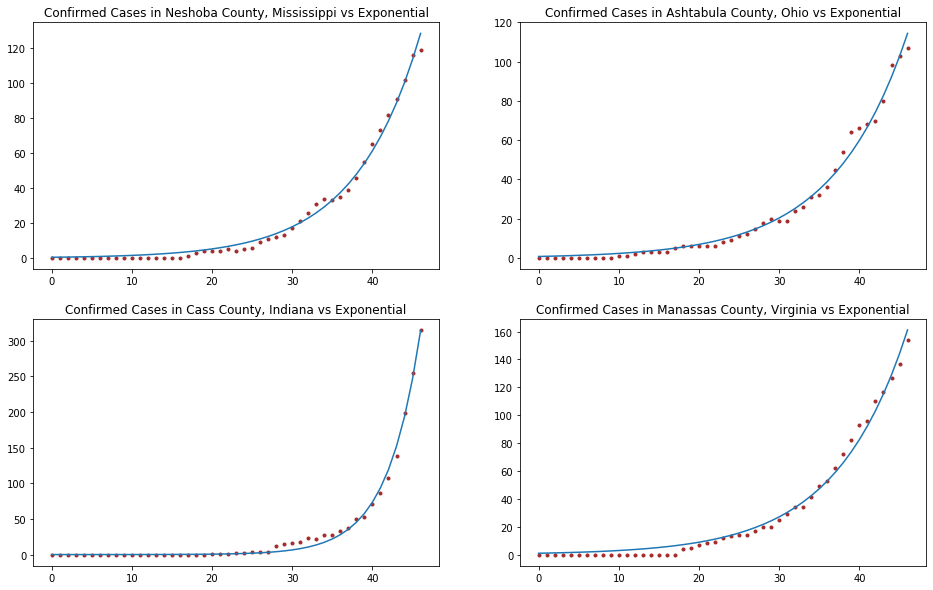

In [10]:
# The R^2 metrics divide the time series into several groups. Let's look at
# examples of each of these groups in turn.
#
# Show some example time series for which a single exponential curve
# has R^2 above 0.99
util.graph_examples(curves, ts_col_name, {"Exponential": curves["Exponential"]},
                    mask=stats['Exp_R^2'] >= r2_thresh)

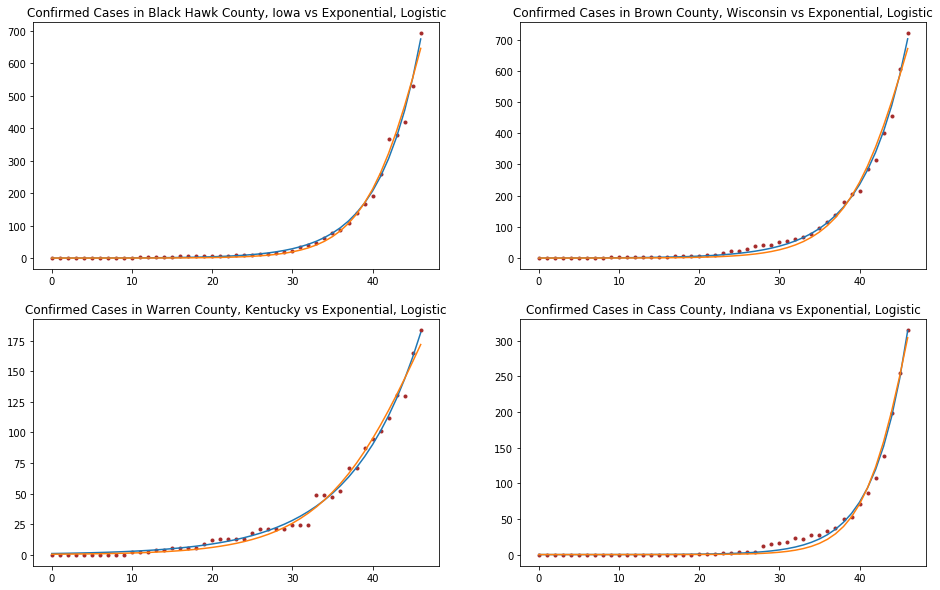

In [11]:
# Are there any time series that fit an exponential curve with R^2 > 0.99
# and fit that exponential curve *better* than they fit a logistic curve?
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"]},
                    mask=(stats['Exp_R^2'] >= r2_thresh) & (stats['Exp_R^2'] > stats['Log_R^2']))

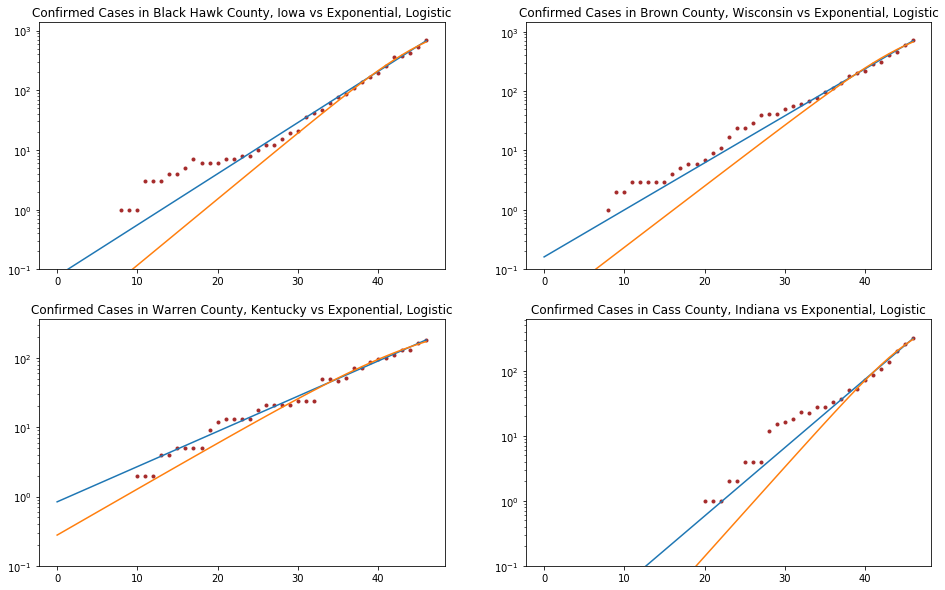

In [12]:
# Previous plots with a log scale on the Y axis
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"]},
                    mask=(stats['Exp_R^2'] >= r2_thresh) & (stats['Exp_R^2'] > stats['Log_R^2']),
                    semilog=True)

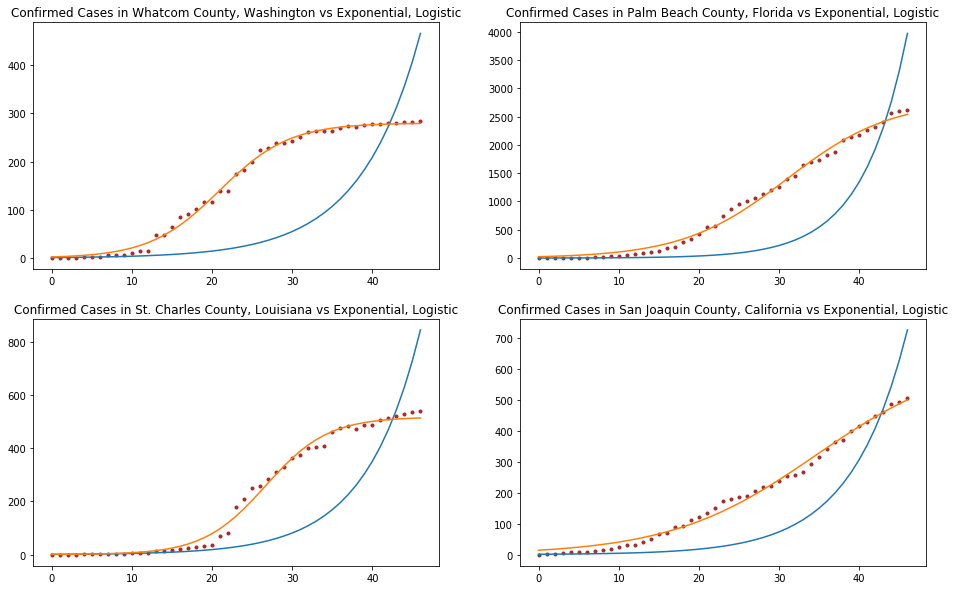

In [13]:
# Let's look at some examples where logistic growth (with a single
# instance of the logistic function) produces a good fit, while an
# exponential growth model does not.
mask = (stats['Log_R^2'] >= r2_thresh) & (stats['Exp_R^2'] < 0.95)
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"]},
                    mask=mask)

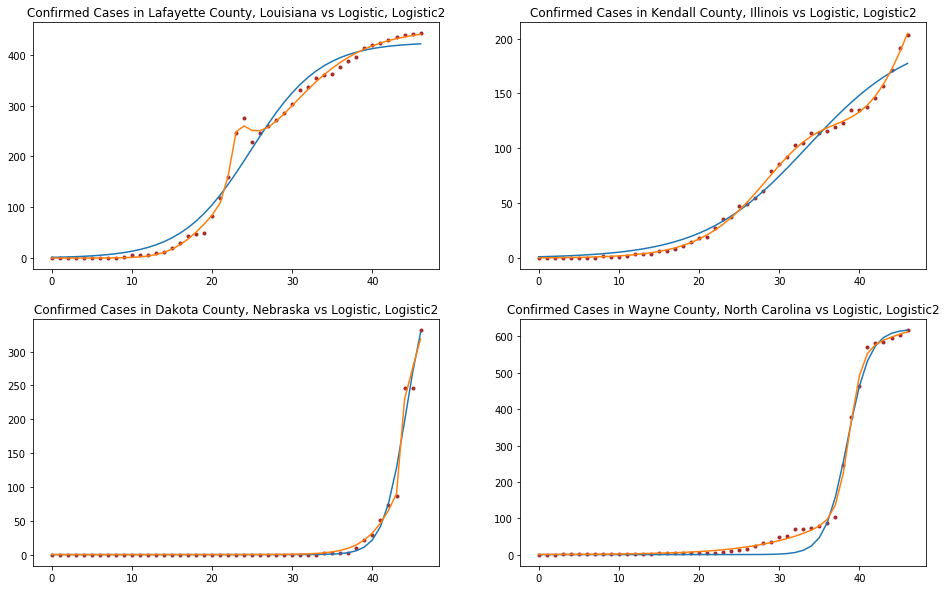

In [14]:
# Look at cases where a mixture of two logistic growth models explains
# the data better than a single logistic growth model.
mask = stats['Log2_R^2'] - stats['Log_R^2'] >= 0.01
#graph_examples(mask, {"Logistic": logistic, "Logistic2": logistic2}, num_to_pick=10)
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=mask)

In [15]:
# Many of these dual-logistic curves have low values for the rate of the
# second logistic function.
# Across the entire data set, what models have logistic rate2 near zero?
small_rate2_mask = params["Log2_Rate2"] < 5e-2
params[small_rate2_mask][metadata_cols + [c for c in params.columns if c.startswith("Log2")]]

,State,County,Population,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,
1073,Alabama,Jefferson,658573,1646.320314,1.406070e+00,30.930859,1618.936007,0.044933,47.000000,10.764860,15.232969
6079,California,San Luis Obispo,283111,2978.649588,8.513175e-01,23.815399,319.984265,0.046072,47.000000,6.040263,8.383861
6085,California,Santa Clara,1927852,406.839629,3.952030e-01,17.396692,4385.961989,0.000000,12.316772,21.927660,29.532609
8031,Colorado,Denver,727211,839.314344,1.747483e-01,14.551042,2898.044555,0.008743,11.511832,18.574674,17.574674
8051,Colorado,Gunnison,17462,259.987680,8.284162e-02,45.849232,260.188361,0.031819,46.771435,9.277352,8.277357
9001,Connecticut,Fairfield,943332,4552.251542,2.612490e-01,24.316439,34846.252704,0.000000,21.857758,40.558995,47.000000
12001,Florida,Alachua,269043,491.268551,1.000000e+01,32.053416,491.126642,0.040273,47.000000,11.208366,16.409871
12031,Florida,Duval,957755,1958.653583,2.890347e+00,47.000000,1964.380793,0.041644,45.758727,16.681694,20.680056
12097,Florida,Osceola,375751,95.193019,9.992763e+00,22.941812,782.229735,0.043136,37.020061,16.879348,21.851466


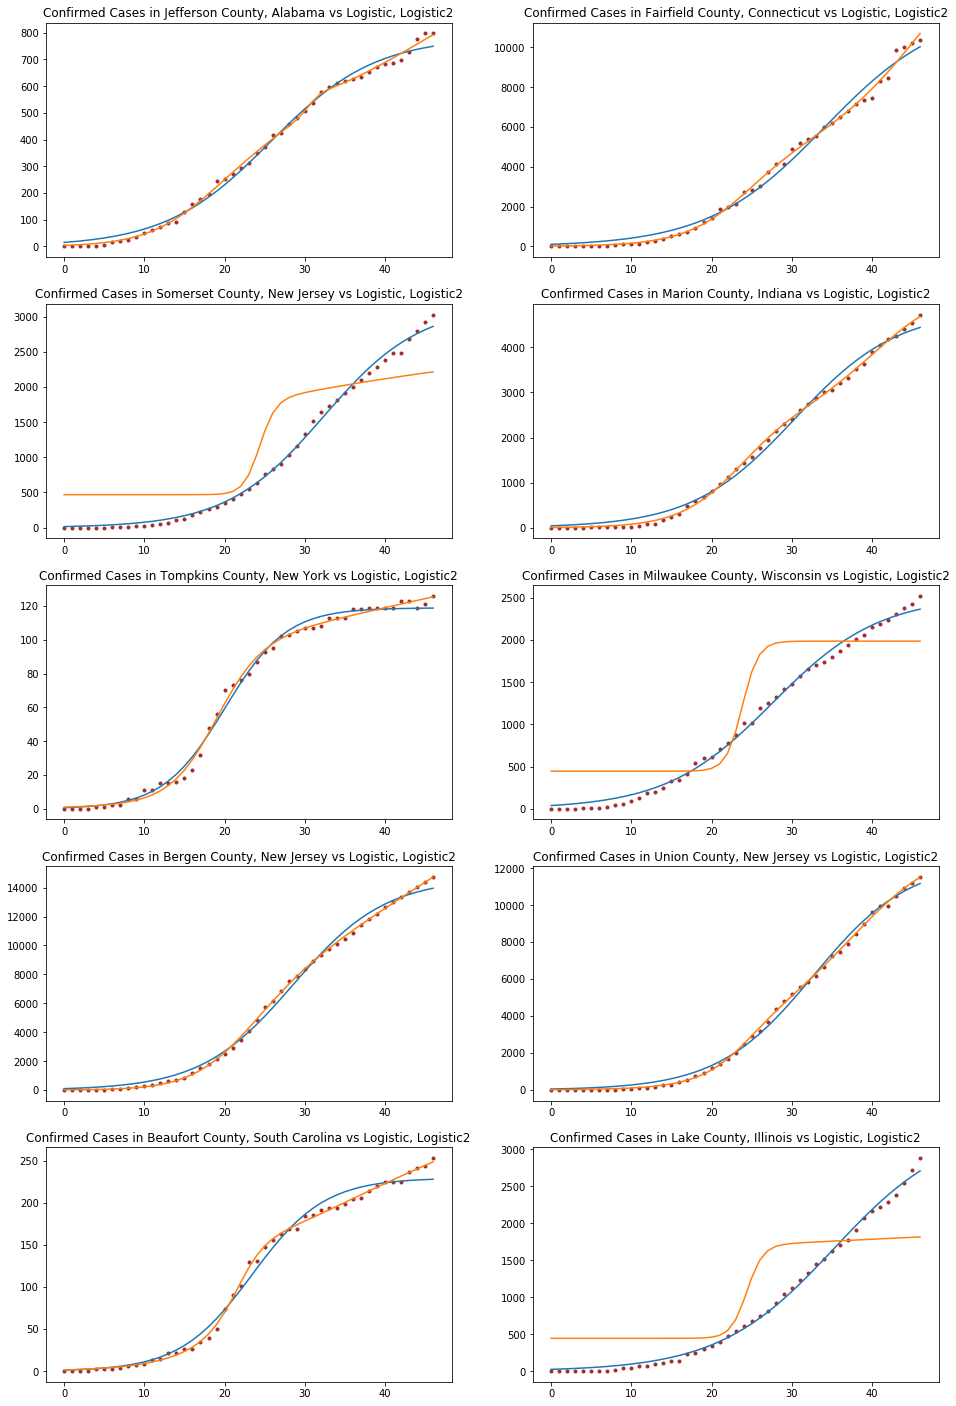

In [16]:
# Show some examples of these cases where Rate2 is small
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=small_rate2_mask,
                    num_to_pick=10)

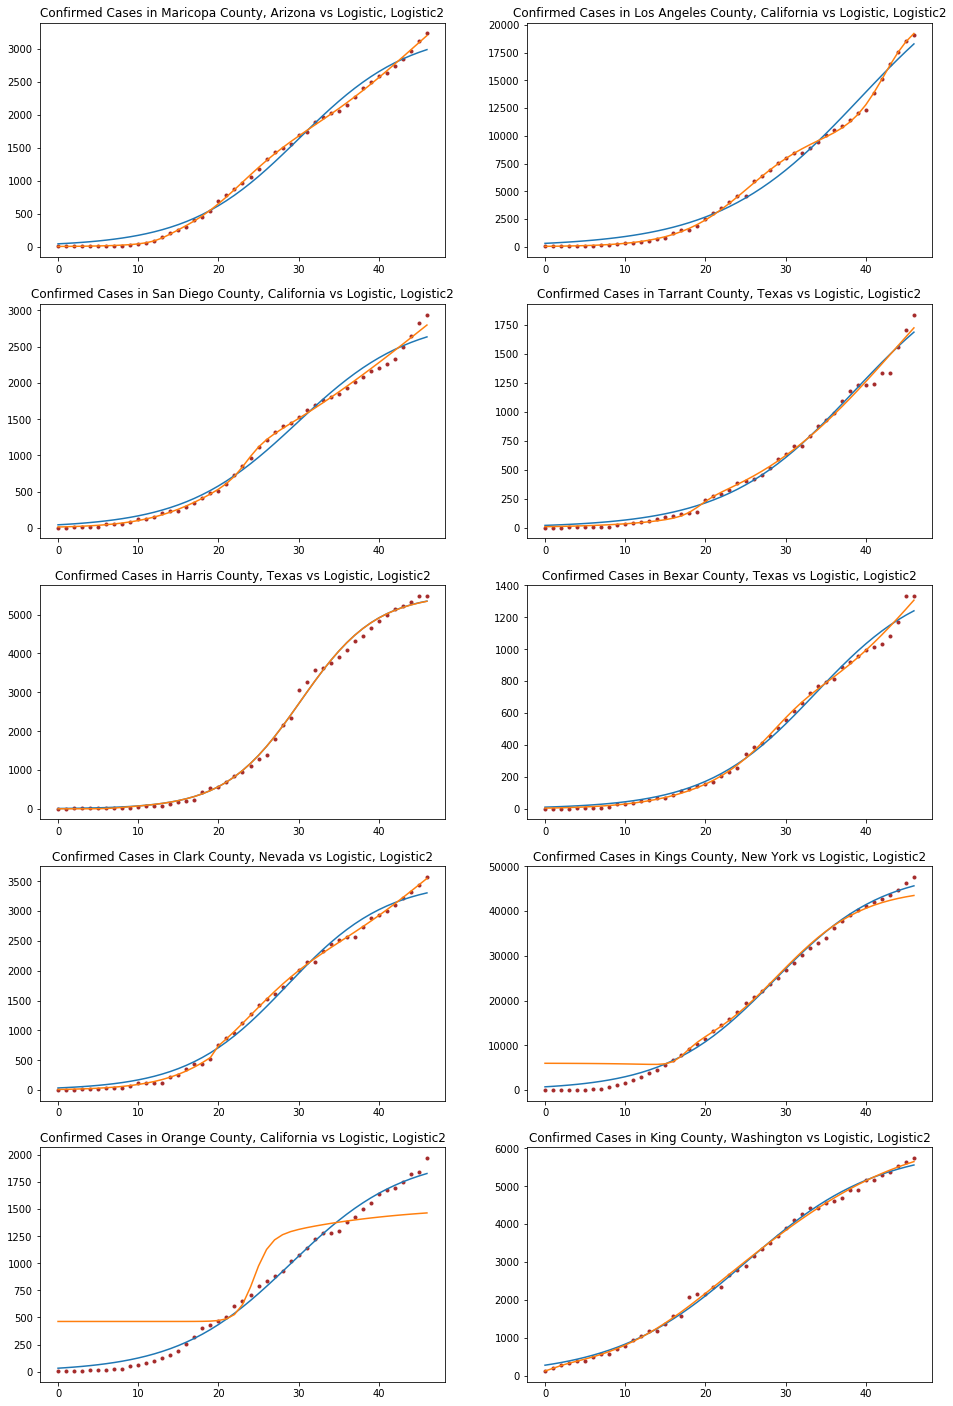

In [17]:
# What about populous counties?
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=curves["Population"] > 2e6,
                    num_to_pick=10)

In [18]:
# What time series are *not* explained by any of our curves?
non_fitting_mask = (stats["Exp_R^2"] < 0.99) & (stats["Log_R^2"] < 0.99) & (stats["Log2_R^2"] < 0.99)
stats[non_fitting_mask]

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
8051,Colorado,Gunnison,17462,-0.088676,0.963424,0.987601
12035,Florida,Flagler,115081,0.927090,0.970544,0.989526
13093,Georgia,Dooly,13390,0.945875,0.979918,0.987844
17089,Illinois,Kane,532403,0.804908,0.988012,0.989731
18029,Indiana,Dearborn,49458,0.599845,0.908013,0.908896
18061,Indiana,Harrison,40515,0.891337,0.979056,0.987650
22097,Louisiana,St. Landry,82124,0.687723,0.980412,0.987651
25005,Massachusetts,Bristol,565217,0.633813,0.976494,0.803109
27027,Minnesota,Clay,64222,0.986170,0.982443,0.982771


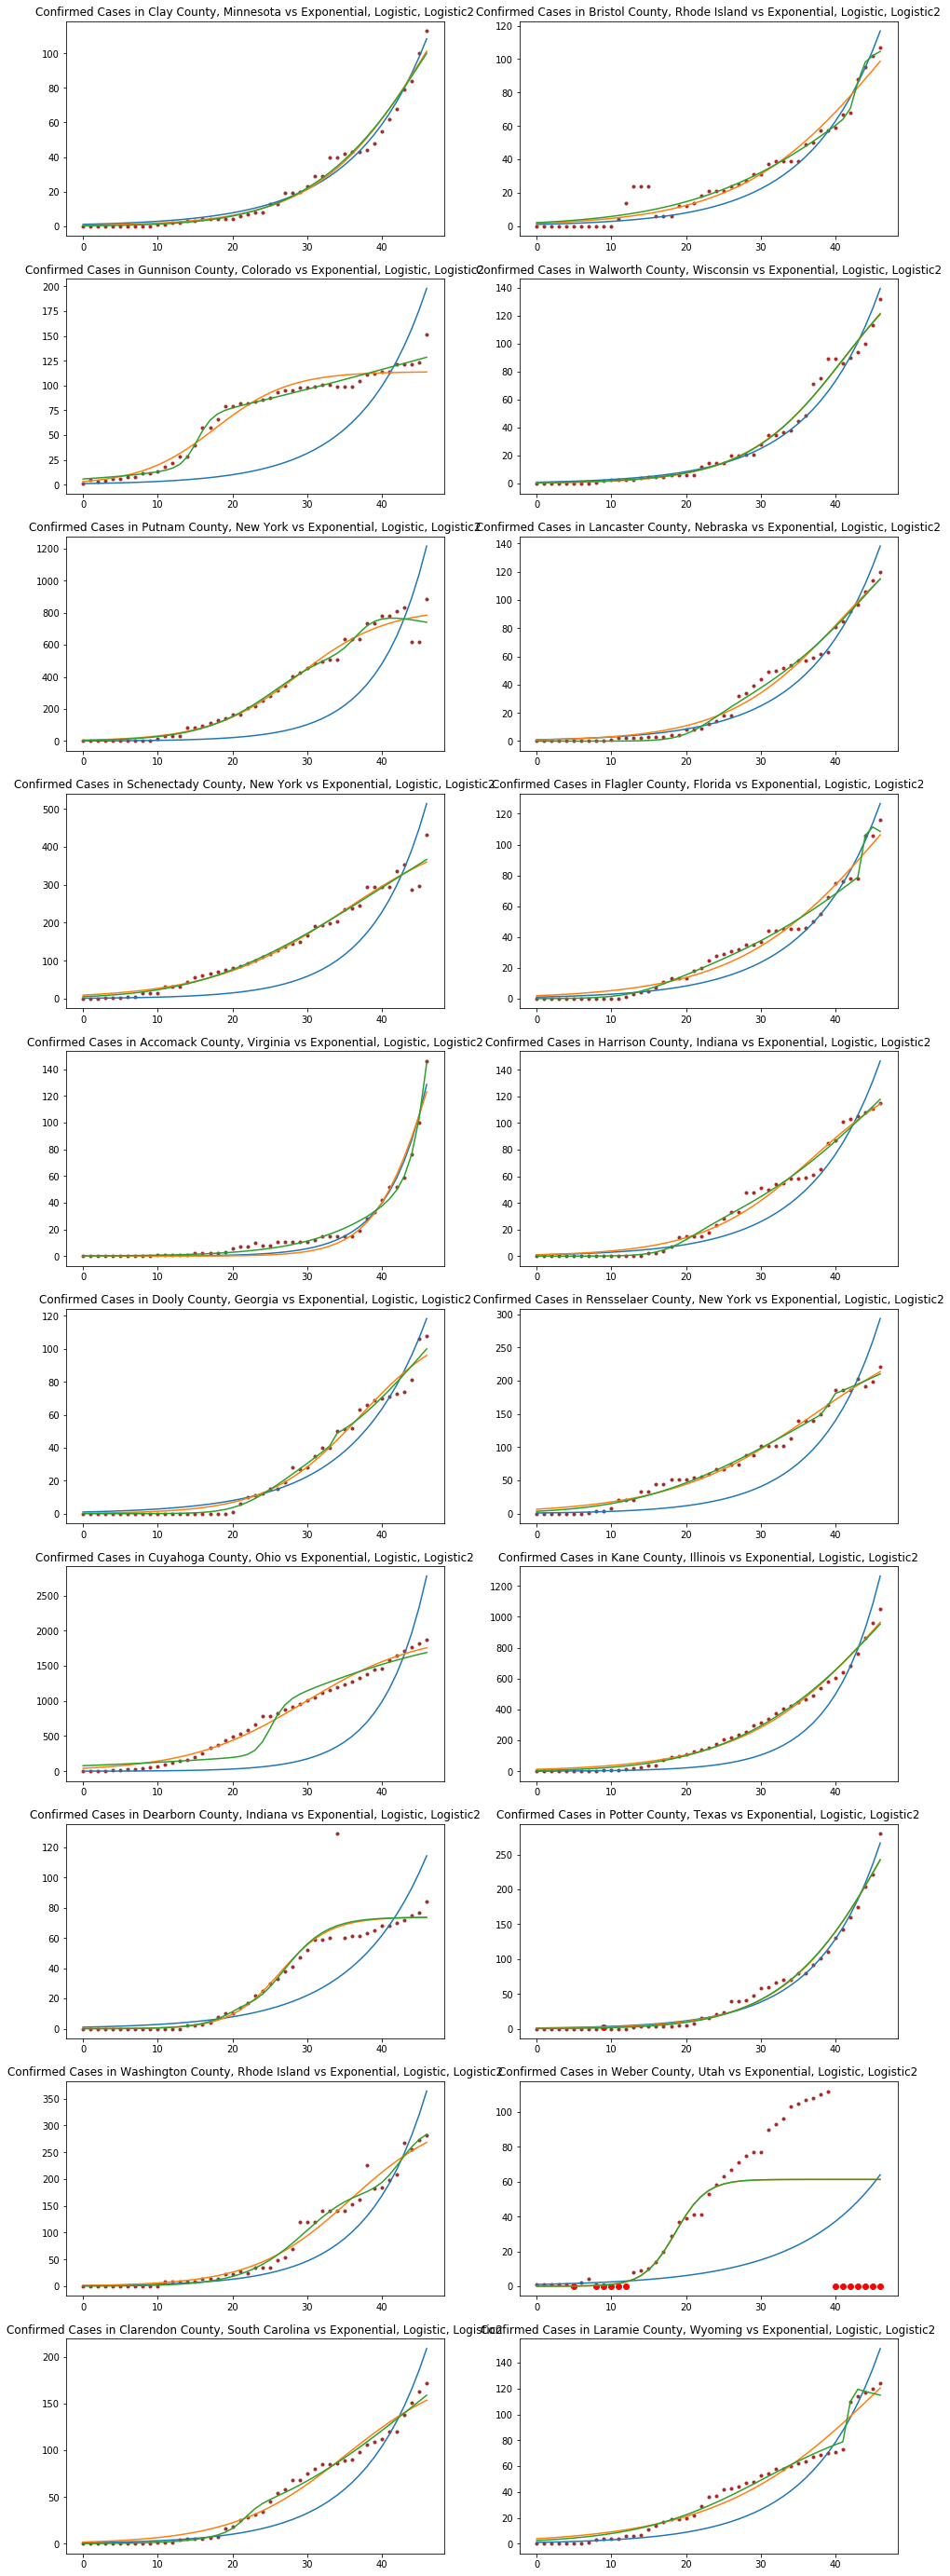

In [19]:
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=non_fitting_mask,
                    num_to_pick=20)